In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *
#from fastai.transforms import *
from fastai.conv_learner import *
#from fastai.model import *
#from fastai.dataset import *
#from fastai.sgdr import *
#from fastai.plots import *

In [3]:
PATH = "./"
IMG_PATH = Path('../data/PPMI_MRI/')

In [4]:
import nibabel as nib
#import pydicom
import glob
import os
import numpy
import seaborn as sns
from itertools import chain
from skimage.transform import resize
from tensorboardX import SummaryWriter
import gc

In [5]:

lstFilesDCM = []  # create an empty list
'''for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))'''

'for dirName, subdirList, fileList in os.walk(PathDicom):\n    for filename in fileList:\n        if ".dcm" in filename.lower():  # check whether the file\'s DICOM\n            lstFilesDCM.append(os.path.join(dirName,filename))'

In [6]:
metadata = pd.read_csv(IMG_PATH / 'mri_T1.csv')

In [7]:
#Shuffle data
metadata = metadata.sample(frac=1).reset_index(drop=True)

In [8]:
metadata[0:5]

,Image Data ID,Subject,Group,Sex,Age,Visit,MDP_UPDRS III,NHY,Acq Date,MRI File Path
0,476223,3304,SWEDD,F,41,7,7,1,2014-05-15,../dat_mri_T1_gz/PPMI_3304_MR_T1-anatomical_Br...
1,407732,3188,Control,M,71,1,0,0,2013-04-03,../dat_mri_T1_gz/PPMI_3188_MR_T1-anatomical_Br...
2,371094,3834,PD,M,69,1,20,1,2012-12-18,../dat_mri_T1_gz/PPMI_3834_MR_T1-anatomical_Br...
3,428795,3829,PD,F,68,5,19,1,2013-10-01,../dat_mri_T1_gz/PPMI_3829_MR_T1-anatomical_Br...
4,486733,3176,PD,M,63,5,46,2,2013-05-29,../dat_mri_T1_gz/PPMI_3176_MR_T1-anatomical_Br...


In [43]:
for file in glob.glob(f'{PATH}../data/PPMI_MRI/**/*.nii'):
    lstFilesDCM.append(file)

In [44]:
len(lstFilesDCM)

643

In [45]:
ptID = []
for i in lstFilesDCM:
    j = i.split("_")[11].strip()
    j = int(j[1:7])
    ptID.append(j)
len(ptID)

643

In [54]:
df = metadata[['Image Data ID','Group','Sex','Age','Subject','MDP_UPDRS III','NHY','Acq Date']].set_index('Image Data ID')
for index, rows in df.iterrows():
    for i in lstFilesDCM:
        j = i.split("_")[11].strip()
        j = int(j[1:7])
        if index == j:
            df.loc[df.index == j, "Filenames"] = i


In [55]:
df = df[df.Group.isin(['Control','PD'])]

In [56]:
df.any().isnull()

Group            False
Sex              False
Age              False
Subject          False
MDP_UPDRS III    False
NHY              False
Acq Date         False
Filenames        False
dtype: bool

In [57]:
df.loc[df['Sex']=='F', 'is_F']=1
df.loc[df['Sex']=='F', 'is_M']=0
df.loc[df['Sex']=='M', 'is_F']=0
df.loc[df['Sex']=='M', 'is_M']=1

In [58]:
df.loc[df['Group']=='Control', 'Group']=0
df.loc[df['Group']=='PD', 'Group']=1

In [59]:
df.to_csv(IMG_PATH / 'df_mri.csv')

In [6]:
df = pd.read_csv(IMG_PATH / 'df_mri.csv')

In [7]:
df.head()

,Image Data ID,Group,Sex,Age,Subject,MDP_UPDRS III,NHY,Acq Date,Filenames,is_F,is_M
0,370798,0,M,64,4018,8,0,2012-02-13,./../data/PPMI_MRI/dat_mri_T1_gz 4/PPMI_4018_M...,0.0,1.0
1,406791,1,M,61,3118,17,2,2013-01-23,./../data/PPMI_MRI/dat_mri_T1_gz 2/PPMI_3118_M...,0.0,1.0
2,428747,1,M,49,3787,12,2,2013-10-30,./../data/PPMI_MRI/dat_mri_T1_gz 2/PPMI_3787_M...,0.0,1.0
3,371034,1,M,77,3826,15,1,2012-08-21,./../data/PPMI_MRI/dat_mri_T1_gz 3/PPMI_3826_M...,0.0,1.0
4,330968,0,M,52,3300,0,0,2011-01-18,./../data/PPMI_MRI/dat_mri_T1_gz 2/PPMI_3300_M...,0.0,1.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

scalea = MinMaxScaler()

print(scalea.fit(df['Age'].values.reshape(-1,1)))

df['age_scale'] = scalea.transform(df['Age'].values.reshape(-1,1))

MinMaxScaler(copy=True, feature_range=(0, 1))


/home/brainvistec4/miniconda3/envs/fastai/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [9]:
from sklearn.model_selection import train_test_split
X_train_tmp, X_test_tmp, param_train_tmp, param_test_tmp, y_train_tmp, y_test_tmp = train_test_split(df, df[['is_F','is_M','age_scale']], df['Group'], test_size=0.2)

from sklearn.model_selection import train_test_split
X_train_tmp, X_val_tmp, param_train_tmp, param_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, param_train_tmp, y_train_tmp, test_size=0.3)

In [11]:
lstFilesDCM_train = []  # create an empty list
lstFilesDCM_test = []
lstFilesDCM_val = []
lstFilesDCM_train = X_train_tmp['Filenames'].values
lstFilesDCM_train = lstFilesDCM_train.tolist()
lstFilesDCM_test = X_test_tmp['Filenames'].values
lstFilesDCM_test = lstFilesDCM_test.tolist()
lstFilesDCM_val = X_val_tmp['Filenames'].values
lstFilesDCM_val = lstFilesDCM_val.tolist()

For NORMAL Image

In [10]:
#Training Set

In [403]:
img = nib.load(lstFilesDCM_train[68])
im = []

In [404]:
ds = img.get_fdata()[15]
for i in range(16,161):
    ds = np.dstack((ds,img.get_fdata()[i]))
ds = ds.transpose(1,0,2)

#Select cut
ds_3d_a = ds[77,25:235,:]
for i in range(80,240,3):
    ds_3d_a = np.dstack((ds_3d_a,ds[i,25:235,:]))
ds_3d_a = ds_3d_a.transpose(2,0,1)
ds_3d_a = ds_3d_a / 2350

im.append(ds_3d_a)

In [405]:
np.asarray(im).shape

(1, 55, 210, 146)

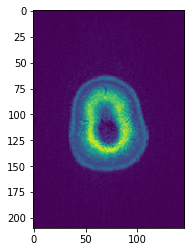

In [409]:
plt.imshow(np.asarray(im)[0,54,:,:])

In [52]:
plt.imshow(resize(mri, (128, 120), anti_aliasing=True))

NameError: name 'mri' is not defined

/home/brainvistec4/miniconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


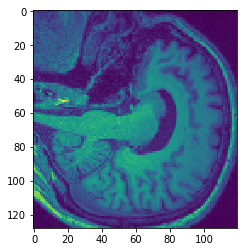

In [71]:
plt.imshow(resize(img.get_fdata()[80,40:230,60:230], (128, 120), anti_aliasing=True))

#### 128x120

In [73]:
# loop through all the DICOM files
image_array_train =[]

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[25,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(28,146,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)
'''
for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[26,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(29,147,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[27,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(30,148,3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)
    
for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[145,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(142,24,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[146,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(143,25,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    ds_3d = resize(ds.get_fdata()[147,40:230,60:230], (128, 120), mode='constant', anti_aliasing=True)
    for i in range(144,26,-3):
        ds_3d = np.dstack((ds_3d,resize(ds.get_fdata()[i,40:230,60:230], (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)'''
    
image_array_train = np.asarray(image_array_train,dtype='int64')
#image_array_train = image_array_train.transpose(image_array_train, (0,2,3,1))
#image_array_train = image_array_train/1278.008826530314

#image_array_train.shape

In [ ]:
img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d_a = ds[100,40:220,:]
    for i in range(103,231,3):
        ds_3d_a = np.dstack((ds_3d_a,ds[i,40:220,:]))

## Load Training Set

In [12]:
image_array_train = []
image_array_train_a = []
image_array_train_ai = []
image_array_train_b = []
image_array_train_bi = []
image_array_train_c = []
image_array_train_ci = []

for filenameDCM in lstFilesDCM_train:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d_a = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d_a = np.dstack((ds_3d_a,ds[i,40:220,:]))        
    ds_3d_a = ds_3d_a.transpose(2,0,1)
    ds_3d_a = ds_3d_a / 2350
    image_array_train_a.append(ds_3d_a)
    gc.collect()
    
    
    ds_3d_ai = ds[80,40:220,::-1]
    for i in range(83,241,3):
        ds_3d_ai = np.dstack((ds_3d_ai,ds[i,40:220,::-1]))
    ds_3d_ai = ds_3d_ai.transpose(2,0,1)
    ds_3d_ai = ds_3d_ai / 2350
    image_array_train_ai.append(ds_3d_ai)
    gc.collect()
    
    ds_3d_b = ds[81,40:220,:]
    for i in range(84,242,3):
        ds_3d_b = np.dstack((ds_3d_b,ds[i,40:220,:]))
    ds_3d_b = ds_3d_b.transpose(2,0,1)
    ds_3d_b = ds_3d_b / 2350
    image_array_train_b.append(ds_3d_b)
    gc.collect()
    
    ds_3d_bi = ds[81,40:220,::-1]
    for i in range(84,242,3):
        ds_3d_bi = np.dstack((ds_3d_bi,ds[i,40:220,::-1]))
    ds_3d_bi = ds_3d_bi.transpose(2,0,1)
    ds_3d_bi = ds_3d_bi / 2350
    image_array_train_bi.append(ds_3d_bi)
    gc.collect()
    
    ds_3d_c = ds[82,40:220,:]
    for i in range(85,243,3):
        ds_3d_c = np.dstack((ds_3d_c,ds[i,40:220,:]))
    ds_3d_c = ds_3d_c.transpose(2,0,1)  
    ds_3d_c = ds_3d_c / 2350
    image_array_train_c.append(ds_3d_c)
    gc.collect()
    
    ds_3d_ci = ds[82,40:220,::-1]
    for i in range(85,243,3):
        ds_3d_ci = np.dstack((ds_3d_ci,ds[i,40:220,::-1]))
    ds_3d_ci = ds_3d_ci.transpose(2,0,1)
    ds_3d_ci = ds_3d_ci / 2350
    image_array_train_ci.append(ds_3d_ci)
    gc.collect()



In [13]:
image_array_train1 = np.vstack((image_array_train_a,image_array_train_ai))
image_array_train2 = np.vstack((image_array_train_b,image_array_train_bi))
image_array_train3 = np.vstack((image_array_train_c,image_array_train_ci))
image_array_train = np.vstack((image_array_train1,image_array_train2,image_array_train3))

image_array_train.shape

(1536, 54, 180, 135)

In [14]:
numpy.save('mri_train_array', image_array_train)

In [9]:
image_array_train = np.load('mri_train_array.npy')

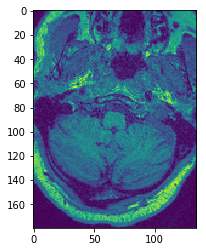

In [17]:
plt.imshow(image_array_train[400,0,:,:])

In [18]:
#Validation set

In [19]:
image_array_val =[]

    
for filenameDCM in lstFilesDCM_val:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d = np.dstack((ds_3d,ds[i,40:220,:]))        
    ds_3d = ds_3d.transpose(2,0,1)
    ds_3d = ds_3d / 2350
    image_array_val.append(ds_3d)
    gc.collect()
    

image_array_val = np.asarray(image_array_val, dtype='float64')
image_array_val.shape

(111, 54, 180, 135)

In [20]:
image_array_val.shape

(111, 54, 180, 135)

In [21]:
numpy.save('mri_val_array', image_array_val)

In [10]:
image_array_val = np.load('mri_val_array.npy')

In [14]:
image_array_train = np.asarray(image_array_train,dtype='float64')
image_array_val = np.asarray(image_array_val,dtype='float64')

In [37]:
#Test set

In [ ]:
image_array_test =[]

    
for filenameDCM in lstFilesDCM_test:
    img = nib.load(filenameDCM)
    ds = img.get_fdata()[20]
    for i in range(21,155):
        ds = np.dstack((ds,img.get_fdata()[i]))
    ds = ds.transpose(1,0,2)
    
    #Select cut
    ds_3d = ds[80,40:220,:]
    for i in range(83,241,3):
        ds_3d = np.dstack((ds_3d,ds[i,40:220,:]))        
    ds_3d = ds_3d.transpose(2,0,1)
    ds_3d = ds_3d / 2350
    image_array_test.append(ds_3d)
    gc.collect()
    

image_array_test = np.asarray(image_array_test, dtype='float64')
image_array_test.shape

In [ ]:
numpy.save('mri_test_array', image_array_test)

### Data Augmented Image_array_train

In [43]:
from scipy.ndimage import interpolation

In [ ]:
rotR = interpolation.rotate(image_array_train,-5,axes=(3,2),mode='constant',reshape=False)
numpy.save('image_array_train_aug', rotR)

In [44]:
rotR8 = interpolation.rotate(image_array_train,-8,axes=(3,2),mode='constant',reshape=False)
np.save('image_array_train_aug3', rotR8)

In [ ]:
rotL = interpolation.rotate(image_array_train,5,axes=(3,2),mode='constant',reshape=False)
numpy.save('image_array_train_aug2', rotL)

In [ ]:
rotL8 = interpolation.rotate(image_array_train,8,axes=(3,2),mode='constant',reshape=False)
np.save('image_array_train_aug4', rotL8)

### Load Image Array

In [5]:
image_array_train = np.load('mri_train_array.npy')
#image_array_train = np.load('image_array_train_aug.npy')
#image_array_train = np.load('image_array_train_aug2.npy')
#image_array_train = np.load('image_array_train_aug3.npy')
#image_array_train = np.load('image_array_train_aug4.npy')

image_array_val = np.load('mri_val_array.npy')
#image_array_test = np.load('mri_test_array.npy')

### Y , Param

In [6]:
y_train = y_train_tmp.values
y_train = y_train.astype('int64')
y_train = np.hstack((y_train,y_train,y_train))
y_train = np.hstack((y_train,y_train))
y_val = y_val_tmp.values
y_val = y_val.astype('int64')
#y_val= np.hstack((y_val,y_val,y_val))
y_test = y_test_tmp.values
y_test = y_test.astype('int64')
#y_val= np.hstack((y_val,y_val,y_val))

NameError: name 'y_train_tmp' is not defined

In [23]:
y_train.shape,y_val.shape,y_test.shape

((1536,), (111,), (92,))

In [24]:
numpy.save('mri_ytrain_array', y_train)
numpy.save('mri_yval_array', y_val)
numpy.save('mri_ytest_array', y_test)

In [25]:
param_train = param_train_tmp.values
params = []
for i in param_train:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_train = np.asarray(params)
del(params)

In [26]:
param_val = param_val_tmp.values
params = []
for i in param_val:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_val = np.asarray(params)
del(params)

param_test = param_test_tmp.values
params = []
for i in param_test:
    stack = []
    stack.append(i)
    stack = stack*10
    params.append(stack)
param_test = np.asarray(params)
del(params)

In [27]:
param_train = param_train.astype('float64')
param_val = param_val.astype('float64')
param_test = param_test.astype('float64')

In [28]:
#x6 Param match training Image
param_train = np.vstack((param_train,param_train,param_train))
param_train = np.vstack((param_train,param_train))

In [29]:
param_train.shape

(1536, 10, 3)

In [30]:
numpy.save('mri_paramtrain_array', param_train)
numpy.save('mri_paramval_array', param_val)
numpy.save('mri_paramtest_array', param_test)

### Load y,param

In [6]:
y_val = np.load('mri_yval_array.npy')
y_train = np.load('mri_ytrain_array.npy')
#y_test = np.load('mri_ytest_array.npy')
param_val = np.load('mri_paramval_array.npy')
param_train = np.load('mri_paramtrain_array.npy')
#param_test = np.load('mri_paramtest_array.npy')

In [7]:
y_train = y_train.astype('float64')
y_val = y_val.astype('float64')

### Fastai library

#### Pretrained Resnet

In [77]:
class  ConvWithMeta(nn.Module):
    def __init__(self):
        super(ConvWithMeta, self).__init__()
        head_layer = [nn.Conv2d(1, 3, kernel_size=1, bias=False, stride=1, padding=0)]
        self.head_layer = nn.Sequential(*head_layer)
        resnet_layers = list(resnet34(True).children())[:8]
        self.features = nn.Sequential(*resnet_layers,nn.Dropout2d(0.5))
        for param in self.features.parameters():
            param.requires_grad = False
        self.bns = nn.ModuleList([nn.BatchNorm1d(27660), nn.BatchNorm1d(1024)])
        self.lins = nn.ModuleList([nn.Linear(27660,1024), nn.Linear(1024, 1)])
        for o in self.lins: kaiming_normal(o.weight.data)
        self.fc_model = nn.Sequential(*self.fc_layers()).cuda()
        
    def fc_layers(self):
        return [self.bns[0], nn.Dropout(0.5), self.lins[0], nn.LeakyReLU(), 
                self.bns[1], nn.Dropout(0.5), self.lins[1]] 
        
    def forward(self, x1, x2):
        for i in range(54):
            x_clone = x1[:,i,:,:].clone()
            x_clone = x_clone.unsqueeze(1)
            x_clone = self.head_layer(x_clone)           
            x_clone = self.features(x_clone)
            x_clone = nn.AdaptiveMaxPool2d((1,1))(x_clone)
            if i == 0:
                out = x_clone
            else:
                out = torch.cat((out,x_clone),1)
        out=out.squeeze()
        out = torch.cat((out,x2[:,0],x2[:,1],x2[:,2],x2[:,3]),1)
        out = self.fc_model(out)
        return out.squeeze()
        '''
        x1 = x1.unsqueeze(1)
        x1 = self.head_layer(x1)
        x1 = self.features(x1)
        x1 = nn.AdaptiveMaxPool2d((1,1))(x1)
        x1 = x1.view(x1.size(0), -1)
        x = torch.cat([x1, x2], 1)
        x = self.fc_model(x)
        x = x.squeeze()
        return x'''

In [78]:
class MetaModel(BasicModel):
    def get_layer_groups(self):
        m=self.model
        return m

In [79]:
class  MetaLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.binary_cross_entropy_with_logits

In [80]:
class MetaDataset(BaseDataset):
    """ Dataset where x=(x1,x2) where x1 is an image.
    """
    def __init__(self, fnames, x2, y, transform, path):
        self.path,self.fnames,self.y,self.x2 = path,fnames,y,x2
        assert(len(fnames)==len(y))
        super().__init__(transform)

    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x1, x2 = self.get_x(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x1, x2), y)
    
    def __len__(self): return len(self.y)
    
    def get_x(self, i):
        im = x1
        x2 = np.expand_dims(self.x2[i], axis=1)
        return np.array(im, dtype=np.float32)/255., x2
    
    def get_n(self): return len(self.y)
    def get_y(self, i): return self.y[i]
    
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    
    def get_c(self): return 1
    
    def get_sz(self): return self.transform.sz

In [81]:
class MetaArraysDataset(BaseDataset):
    def __init__(self, x, param, y, transform, path):
        self.path = path
        self.x,self.y, self.param = x, y , param
        assert(len(x)==len(y))
        super().__init__(transform)
        
    def __getitem__(self, idx):
        """ This function should return a list.
        """
        x = self.get_x(idx)
        param = self.get_param(idx)
        y = self.get_y(idx)
        return self.get(self.transform, (x, param), y)
   
    def get(self, tfm, x, y):
        x1, x2 = x
        if tfm is None:
            return [x1, x2, y] 
        x1,y = tfm(x1,y)
        return [x1, x2, y]
    def get_c(self): return int(self.y.max())+1
    def get_x(self, i): return self.x[i]
    def get_param(self,i): return self.param[i]
    def get_y(self, i): return self.y[i]
    def get_n(self): return len(self.y)
    def get_sz(self): return self.x.shape[1]

In [82]:
bs=4; sz=128
#f_model = resnet34

In [83]:
USE_GPU=True

In [84]:
class ModelMetaData(ImageClassifierData):
    
    @classmethod
    def get_ds(self, fn, trn, val, tfms, path, test=None):
        res = [
            fn(trn[0], trn[1], trn[2], tfms[0], path), # train
            fn(val[0], val[1], val[2], tfms[1], path), # val
            fn(trn[0], trn[1], trn[2], tfms[1], path), # fix
            fn(val[0], val[1], val[2], tfms[0], path)  # aug
        ]
        if test:
            test_lbls = np.zeros((len(test),1))
            res += [
                fn(test, test_lbls, tfms[1], path), # test
                fn(test, test_lbls, tfms[0], path)  # test_aug
            ]
        else: res += [None,None]
        return res
    
    @classmethod
    def from_csv(self, path, folder, csv_fname, bs=bs, tfms=(None,None),val_idxs=None, 
                 suffix='', test_name=None, skip_header=True, num_workers=4):
        fnames,x2,y = csv_source2(folder, csv_fname, skip_header, suffix)
        ((val_fnames, trn_fnames), (val_x2, trn_x2), (val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), x2, y)

        test_fnames = read_dir(path, test_name) if test_name else None
        datasets = self.get_ds(MetaDataset, (trn_fnames,trn_x2,trn_y), (val_fnames,val_x2,val_y),tfms=tfms, path=path)
        return self(path, datasets, bs, num_workers, classes=1)
    
    @classmethod
    def from_arrays(self, path, trn, val, bs=bs, tfms=(None,None), classes=None, num_workers=4, test=None):
        trn_x1 , val_x1 = trn[0],val[0]
        trn_x2 , val_x2 = trn[1],val[1]
        trn_y , val_y = trn[2],val[2]
        #test_x1, test_x2, test_y = test[0],test[1],test[2]
        datasets = self.get_ds(MetaArraysDataset, (trn_x1,trn_x2,trn_y), (val_x1,val_x2,val_y) ,tfms=tfms,path=path)
        return self(path, datasets, bs, num_workers, classes=classes)
    
        
    def get_learner(self):
        model = ConvWithMeta()
        #model = Darknet([1,2,4,6,3], num_classes=1, nf=32)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #m = nn.DataParallel(m, [1,2,3])
        return MetaLearner(self, MetaModel(model.to(device)), opt_fn=optim.Adam)

In [85]:
data = ModelMetaData.from_arrays('.', trn=(image_array_train,param_train,y_train),val=(image_array_val,param_val,y_val))

In [86]:
learner = data.get_learner()


In [18]:
learner.lr_find()

 62%|██████▎   | 240/384 [08:47<05:16,  2.20s/it, loss=2.07]

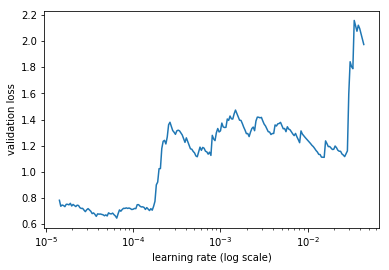

In [20]:
learner.sched.plot()

In [88]:
learner.fit(1e-4,2)

epoch      trn_loss   val_loss                               
    0      0.419343   0.90033   
 12%|█▏        | 46/384 [01:37<11:55,  2.12s/it, loss=0.489]

KeyboardInterrupt: 

In [89]:
from scipy.special import expit
pred = expit(learner.predict())
pred

array([0.98131, 0.98352, 0.88849, 0.99101, 0.98836, 0.99982, 0.94574, 0.80097, 0.89086, 0.9931 , 0.81136,
       0.98023, 0.98714, 0.99649, 0.95826, 0.84595, 0.99708, 0.92609, 0.99952, 0.94614, 0.94075, 0.87874,
       0.97801, 0.99228, 0.98609, 0.93586, 0.95878, 0.29151, 0.98643, 0.98963, 0.98258, 0.79172, 0.84671,
       0.99149, 0.9826 , 0.98758, 0.986  , 0.98032, 0.9946 , 0.92846, 0.9951 , 0.86302, 0.53077, 0.69919,
       0.99925, 0.99777, 0.95551, 0.96029, 0.90396, 0.97007, 0.98139, 0.99862, 0.99899, 0.71701, 0.99094,
       0.99123, 0.96666, 0.99358, 0.97375, 0.99657, 0.99441, 0.99375, 0.9952 , 0.83555, 0.92499, 0.95271,
       0.86417, 0.95752, 0.99551, 0.99873, 0.99867, 0.9856 , 0.99273, 0.98916, 0.72795, 0.90337, 0.80713,
       0.99334, 0.99902, 0.98052, 0.21823, 0.99586, 0.99576, 0.99953, 0.99961, 0.99594, 0.98331, 0.92618,
       0.99301, 0.66916, 0.9958 , 0.45879, 0.98861, 0.55469, 0.99082, 0.99689, 0.64341, 0.99745, 0.87676,
       0.98962, 0.98702, 0.98046, 0.96546, 0.9

In [283]:
predict=[]
for i in pred:
    if i >= 0.3:
        predict.append(1)
    else:
        predict.append(0)

In [284]:
fin = ((y_val)==np.array(predict))

In [285]:
print('Accuracy')
np.count_nonzero(fin == True) / len(fin)

Accuracy


0.7567567567567568

In [286]:
print('False negative')
np.sum((y_val)>np.array(predict))/len(fin)

False negative


0.018018018018018018

In [287]:
print('False positive')
np.sum((y_val)<np.array(predict))/len(fin)

False positive


0.22522522522522523

In [288]:
sklearn.metrics.precision_recall_fscore_support(y_val, np.array(predict))

(array([0.     , 0.77064]),
 array([0.     , 0.97674]),
 array([0.     , 0.86154]),
 array([25, 86]))

In [76]:
learner.save('3D_MRI_resnet34_classify_PD')

In [87]:
learner.load('3D_MRI_resnet34_classify_PD')

In [29]:
lr=[3e-5,6e-5,1e-4]

In [30]:
for j in range(2):
    for i in lr:
        print(i)
        learner.fit(i,1)

3e-05


epoch      trn_loss   val_loss                               
    0      0.380577   0.818091  

6e-05


epoch      trn_loss   val_loss                               
    0      0.384501   0.932408  

0.0001


epoch      trn_loss   val_loss                               
    0      0.54069    1.057876  

3e-05


epoch      trn_loss   val_loss                               
    0      0.348768   1.057993  

6e-05


epoch      trn_loss   val_loss                               
    0      0.451195   1.031317  

0.0001


epoch      trn_loss   val_loss                               
    0      0.428745   1.181388  



In [34]:
np.count_nonzero(y_val == 1) / len(y_val)

0.7747747747747747

### Load dataset

In [ ]:
X_train = torch.utils.data.DataLoader(image_array_train, batch_size=4)
param_train = torch.utils.data.DataLoader(param_train, batch_size=4)
y_train = torch.utils.data.DataLoader(y_train, batch_size=4)
X_val = torch.utils.data.DataLoader(image_array_val, batch_size=4)
param_val = torch.utils.data.DataLoader(param_val, batch_size=4)
y_val = torch.utils.data.DataLoader(y_val, batch_size=4)
#X_test = torch.utils.data.DataLoader(image_array_test, batch_size=1)
#param_test = torch.utils.data.DataLoader(param_test, batch_size=1)
#y_test = torch.utils.data.DataLoader(y_test, batch_size=1)

#del(image_array_train,image_array_val)
#del(image_array_train,image_array_val,image_array_test)
#del(X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp,param_train_tmp,param_val_tmp,param_test_tmp)

### Darknet

In [1]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv3d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm3d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=False))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x.clone())))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        #Weight init Kaiming's
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                m.weight = nn.init.kaiming_normal(m.weight, mode='fan_out')
            elif isinstance(m, nn.BatchNorm3d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
        features = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            features += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2                        
        features += [nn.AdaptiveMaxPool3d((7,7,7)),nn.Dropout(p=0.1), Flatten()]        
        self.features = nn.Sequential(*features)
        fc1 = [nn.Linear(87838, 512),nn.BatchNorm1d(512), nn.LeakyReLU(negative_slope=0.1, inplace=False)]
        self.fc1 = nn.Sequential(*fc1)
        self.layers = nn.Sequential(nn.Linear(512,1))
        
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x1 = self.features(x)
        x = torch.cat((x1,y[:,:,0],y[:,:,1],y[:,:,2]),1)
        x = self.fc1(x)
        x = F.dropout(x, p=0.1, training=self.training)        
        return self.layers(x)


NameError: name 'nn' is not defined

In [ ]:
model_save_path = './weights/'

In [ ]:
m = nn.DataParallel(Darknet([1,2,4], num_classes=1, nf=32))
m.double()

#m = nn.DataParallel(m, [1,2,3])
#m.load_state_dict(torch.load(f'{model_save_path}MRI_binary.pth'))

In [ ]:
optimizer = optim.Adam(m.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss().cuda()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.3)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    #m = nn.DataParallel(m)
m.to(device)
print(device)

### Train

In [23]:
losslog=[]
vallog=[]

In [24]:
writer = SummaryWriter()
total_iter=0

In [25]:
def train(niter):
    for epoch in trange(niter):  # loop over the dataset multiple times
        running_loss = 0.0        
        global total_iter
        m.train(True)
        scheduler.step()
        with tqdm(total=len(X_train)) as pbar:
            iterloss=[]
            for i, (x, p, y) in enumerate(zip(X_train,param_train,y_train)):
                x,p,y = x.to(device), p.to(device),y.to(device)

                #i += 1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = m(x.double(),p.double())
                loss = criterion(outputs,y.double().unsqueeze(1))
                
                loss.backward()
                for param in optimizer.param_groups[0]['params']:
                    param.data = param.data.add(-0.0001 * optimizer.param_groups[0]['lr'], param.data)
                optimizer.step()

                pbar.update()

                

                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[%d, %5d]  Train BCElogits loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    losslog.append(running_loss/20)
                    iterloss.append(running_loss/20)
                    running_loss = 0.0
            total_iter +=1
            print(iterloss)
            writer.add_scalar("Trainloss", sum(iterloss)/len(X_train) , total_iter)   
            #Eval
        m.eval()
        with tqdm(total=len(X_val)) as pbar:
            with torch.no_grad():
                truth = []
                predicted =[]
                
                correct = 0
                total = 0
                for i, ( x, p, y) in enumerate(zip(X_val,param_val,y_val)):
                    x,p,y = x.to(device), p.to(device),y.to(device)

                    # forward + backward + optimize
                    corr = []
                    outputs = m(x,p)
                    loss = criterion(outputs,y.double().unsqueeze(1))
                    pred = (F.sigmoid(outputs))
                    for i in pred:
                        if i >= 0.74: corr.append(1)
                        else: corr.append(0)
                    total += y.size(0)
                    correct += (corr == y.cpu().numpy()).sum()
                    predicted.append(pred)
                    truth.append(y)
                    pbar.update()
                    
                    
                
                valloss = loss.item()
                vallog.append(valloss)
                print(f'BCELogitsLoss: {valloss}')
                print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
                #cmat = confusion_matrix(truth, predicted)'''
            
    print('Finished Training')
    return vallog, truth, predicted

In [26]:
torch.backends.cudnn.benchmark=True

In [22]:
TT = train(2)
TT = train(2)
TT = train(2) 

100%|██████████| 384/384 [44:20<00:00,  6.95s/it][0.49718189670130153, 0.48366593091733573, 0.6264471387920707, 0.4988120059301838, 0.448585070760536, 0.5641861059598912, 0.5887009699250932, 0.3880591867141738, 0.5718695460528352, 0.552412808656906, 0.47322727727390496, 0.5350727830679585, 0.5995307235399701, 0.4696958215225129, 0.5153413978090788, 0.584214057644106, 0.4925360596361209, 0.49287178012075117, 0.6248142248611364]

100%|██████████| 28/28 [00:47<00:00,  1.67s/it]BCELogitsLoss: 0.8443207271283745
Accuracy of the network on the val images: 47 %

100%|██████████| 384/384 [44:21<00:00,  6.95s/it][0.4921967083728065, 0.4942458138095006, 0.6255007383400388, 0.49279012521565024, 0.4490506237427109, 0.5594249486513282, 0.5823832632292556, 0.3867052107429553, 0.5777262065762134, 0.5564656903124138, 0.47361629628223384, 0.5344977343284819, 0.6013530620904792, 0.472095478537548, 0.511849738848366, 0.5887739124154819, 0.49136816064161903, 0.48351002999209625, 0.6196501031972905]

100%|

In [24]:
TT

([1.496224524555359,
  1.3873954066554994,
  0.8464490112671553,
  0.803148738325154,
  0.8388930043456891,
  0.8443207271283745,
  0.8424007859376849,
  0.8433444497709922,
  0.8419637401239773,
  0.842986963825279,
  0.8412237296990884],
 [tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  0,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 0,  1,  0,  1], device='cuda:0'),
  tensor([ 0,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  0], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 0,  0,  1,  0], device='cuda:0'),
  tensor([ 0,  1,  1,  0], device='cuda:

In [22]:
losslog

[0.8216930839556836,
 0.7273889307189505,
 0.7050484770270664,
 0.6603270692128373,
 0.6084697376567579,
 0.6401739110063083,
 0.677973989800549,
 0.6151184156194662,
 0.6011729956276718,
 0.6121044903256943,
 0.5942070306609757,
 0.5712814314721877,
 0.5955747608970173,
 0.630971558808566,
 0.49292381938283975,
 0.6123989864729247,
 0.5873489647016091,
 0.5275764086899876,
 0.5742456873814241,
 0.6100052082474657,
 0.5313389779186077,
 0.55498831696233,
 0.5831751010099638,
 0.5393484325491027,
 0.5518956694775604,
 0.5925983874374758,
 0.5414074261666363,
 0.5374308159530965,
 0.590408754907889,
 0.5317504567528731,
 0.4906229524739594,
 0.5801321416269973,
 0.6087667286294643,
 0.430552243547638,
 0.5741049616673435,
 0.5887188617658076,
 0.4976971064264869,
 0.5494343338752765,
 0.6169701390507465,
 0.5110835758836094,
 0.5231164061305629,
 0.5829158560821573,
 0.5219906645187964,
 0.521885130560952,
 0.5968872736659666,
 0.5247032483661205,
 0.5267340879482504,
 0.5934375669897545

In [19]:
def eval():
    m.eval()
    with tqdm(total=len(X_val)) as pbar:
        with torch.no_grad():
            truth = []
            predicted =[]
            correct = 0
            total = 0
            for i, ( x, p, y) in enumerate(zip(X_val,param_val,y_val)):
                x,p,y = x.to(device), p.to(device),y.to(device)

                # forward + backward + optimize
                outputs = m(x,p)
                loss = criterion(outputs,y.double().unsqueeze(1))
                pred = (F.sigmoid(outputs))
                corr=[]
                for i in pred:
                    if i >= 0.48: corr.append(1)
                    else: corr.append(0)
                total += y.size(0)
                correct += (corr == y.cpu().numpy()).sum()
                predicted.append(pred)
                truth.append(y)
                pbar.update()

            valloss = loss.item()
            vallog.append(valloss)
            print(f'BCELogitsLoss: {valloss}')
            print('Accuracy of the network on the val images: %d %%' % (100 * correct / total))
            #cmat = confusion_matrix(truth, predicted)
    return truth,predicted

In [20]:
E = eval()

100%|██████████| 28/28 [00:46<00:00,  1.65s/it]BCELogitsLoss: 1.1701710839226958
Accuracy of the network on the val images: 77 %



In [21]:
E

([tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  0,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 0,  1,  0,  1], device='cuda:0'),
  tensor([ 0,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  1], device='cuda:0'),
  tensor([ 1,  1,  0,  0], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([ 0,  0,  1,  0], device='cuda:0'),
  tensor([ 0,  1,  1,  0], device='cuda:0'),
  tensor([ 1,  1,  0,  0], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  1], device='cuda:0'),
  tensor([ 1,  1,  1,  0], device='cuda:0'),
  tensor([

In [ ]:
TT

In [34]:
vallog

[0.14161952221883126,
 0.21242244258728019,
 0.2270260793053405,
 0.12160173200127454,
 0.25563727439289263,
 0.27877713734014437,
 0.23156528441690682,
 0.21562931521745313,
 0.1469511973247502,
 0.1469511973247502]

### 128x120

In [9]:
# loop through all the DICOM files
image_array_train =[]

for filenameDCM in lstFilesDCM_train:
    ds = nib.load(filenameDCM)
    mri = ds.get_fdata().swapaxes(-2,-1)[25,::-1,::-1]
    ds_3d = resize(mri, (128, 120), mode='constant', anti_aliasing=True)
    for i in range(26,146):
        mri = ds.get_fdata().swapaxes(-2,-1)[i,::-1,::-1]
        ds_3d = np.dstack((ds_3d,resize(mri, (128, 120),mode='constant', anti_aliasing=True)))

    image_array_train.append(ds_3d)

image_array_train = np.asarray(image_array_train, dtype='float64')
image_array_train = image_array_train.reshape(len(lstFilesDCM_train),121,128,120)
image_array_train.shape

(256, 121, 128, 120)

In [10]:
image_array_val =[]

for filenameDCM in lstFilesDCM_val:
    ds = nib.load(filenameDCM)
    mri = ds.get_fdata().swapaxes(-2,-1)[25,::-1,::-1]
    ds_3d = resize(mri, (128, 120), mode='constant', anti_aliasing=True)
    for i in range(26,146):
        mri = ds.get_fdata().swapaxes(-2,-1)[i,::-1,::-1]
        ds_3d = np.dstack((ds_3d,resize(mri, (128, 120),mode='constant', anti_aliasing=True)))

    image_array_val.append(ds_3d)

image_array_val = np.asarray(image_array_val, dtype='float64')
image_array_val = image_array_val.reshape(len(lstFilesDCM_val),121,128,120)
image_array_val.shape



(111, 121, 128, 120)

In [64]:
X_train = torch.utils.data.DataLoader(image_array_train, batch_size=4)
X_val = torch.utils.data.DataLoader(image_array_val, batch_size=4)


In [65]:
TT = train(1)

  0%|          | 0/64 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.cu:58

In [79]:
writer.export_scalars_to_json("./log1.json")
writer.close()

## Validate

In [67]:
def test():
    with torch.no_grad():
        n = len(X_test)
        m.eval()
        predicted = []
        correct = 0
        total = 0
        with tqdm(total=len(X_test)) as pbar:
            with torch.no_grad():
                truth = []
                predicted =[]
                correct = 0
                total = 0
                for i, ( x, p, y) in enumerate(zip(X_test,param_test,y_test)):
                    x,p,y = x.to(device), p.to(device),y.to(device)

                    # forward + backward + optimize
                    outputs = m(x,p)
                    pred = (outputs>=0).long().view(-1)
                    total += y.size(0)
                    correct += (pred == y).sum()
                    predicted.append(pred)
                    truth.append(y)
                    pbar.update()
    
    print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
    return predicted, truth

In [68]:
TEST = test()

  0%|          | 0/92 [00:00<?, ?it/s]
Accuracy of the network on the test images: 28 %


In [20]:
model_save_path = './weights/'

In [23]:
torch.save(m.state_dict(),f'{model_save_path}MRI_binary_maxpool.pth')

In [23]:
#m = Darknet([1,2,4,6,3], num_classes=1, nf=32)
#m.double()
m.load_state_dict(torch.load(f'{model_save_path}MRI_binary.pth'))

In [96]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
m.to(device)
print(device)

cuda:0


In [81]:
sns.pairplot

<function seaborn.axisgrid.pairplot(data, hue=None, hue_order=None, palette=None, vars=None, x_vars=None, y_vars=None, kind='scatter', diag_kind='hist', markers=None, size=2.5, aspect=1, dropna=True, plot_kws=None, diag_kws=None, grid_kws=None)>

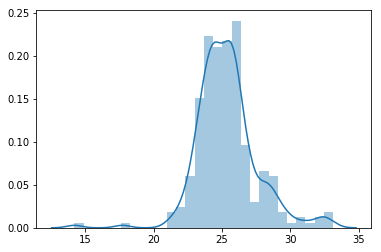

In [117]:
sns.distplot(y_pred)

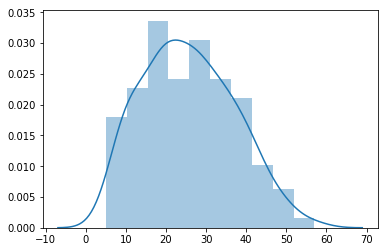

In [118]:
sns.distplot(y_test)

## MultiLabel

In [56]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=False))

class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1=conv_layer(ni, ni//2, ks=1)
        self.conv2=conv_layer(ni//2, ni, ks=3)
        
    def forward(self, x): return x.add_(self.conv2(self.conv1(x.clone())))

class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2,stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]

    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        features = [conv_layer(1, nf, ks=3, stride=1)]
        for i,nb in enumerate(num_blocks):
            features += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2                        
        features += [nn.AdaptiveAvgPool2d(1), Flatten()]        
        self.features = nn.Sequential(*features)
        fc1 = [nn.Linear(1054, 120), nn.BatchNorm1d(120, momentum=0.01), nn.LeakyReLU(negative_slope=0.1, inplace=False)]
        self.fc1 = nn.Sequential(*fc1)
        self.layers = nn.Sequential(nn.Linear(120,num_classes))
        
    def forward(self, x, y):
        x = x.unsqueeze(1)
        x1 = self.features(x)
        x = torch.cat((x1,y[:,:,0],y[:,:,1],y[:,:,2]),1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = F.dropout(x, p=0.2, training=self.training)
        return F.log_softmax(self.layers(x), dim=-1)

In [57]:
ml = Darknet([1,2,4,6,3], num_classes=3, nf=32)
ml.double()
#m = nn.DataParallel(m, [1,2,3])

Darknet(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): ResLayer(
      (conv1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (conv2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_st

In [60]:
optimizer = optim.RMSprop(ml.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.5)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
ml.to(device)
print(device)

### Train

losslog=[]
vallog=[]

def train(niter):
    for epoch in trange(niter):  # loop over the dataset multiple times
        running_loss = 0.0        

        ml.train(True)
        scheduler.step()
        with tqdm(total=len(X_train)) as pbar:
            for i, (x, p, y) in enumerate(zip(X_train,param_train,y_train)):
                x,p,y = x.to(device), p.to(device),y.to(device)

                i += 1
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = m(Variable(x),Variable(p))
                loss = criterion(outputs,Variable(y.long()).unsqueeze(1))
                loss.backward()
                optimizer.step()

                pbar.update()

                # print statistics
                running_loss += loss.item()
                if i % 20 == 19:    # print every 20 mini-batches
                    print('[%d, %5d]  Train MSE loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 20))
                    losslog.append(running_loss/20)
                    running_loss = 0.0
                    
            #Eval
        with tqdm(total=len(X_val)) as pbar:
            with torch.no_grad():
                predicted =[]
                for i, ( x, p, y) in enumerate(zip(X_val,param_val,y_val)):
                    x,p,y = x.to(device), p.to(device),y.to(device)

                    # forward + backward + optimize
                    outputs = m(x,p)
                    pred = outputs.squeeze(1).cpu().numpy().tolist()
                    predicted.append(pred)
                    pbar.update()

                predicted = list(chain.from_iterable(predicted))
                valloss = ((predicted-y_val.dataset) **2).mean()
                #valloss = abs(predicted-y_val.dataset).sum()/len(y_val.dataset)
                vallog.append(valloss)
                print(f'Val MSE loss: {valloss}')
            
    print('Finished Training')
    return losslog,vallog

cuda:0


In [61]:
MUL = train(1)

  0%|          | 0/65 [00:00<?, ?it/s]


RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1524586445097/work/aten/src/THC/generic/THCStorage.cu:58